# Thermal emission noise of HZG NIT ch4

Revised version 3.
2022-05-10 H. Akitaya (PERC, CIT)


## Instrumental parameters.

In [1]:
import sys
import os
import math

import numpy as np
import astropy.units as u

In [2]:
from hzgdev.phot import simimg

In [3]:
params = simimg.HZGParams()

In [4]:
# Get attributions.
attars = [x for x in dir(params) if not x.startswith('_')]

In [5]:
# Show attributions.
attars = [x for x in dir(params) if not x.startswith('_')]
for attar in attars:
    print('params.{} = {}'.format(attar, getattr(params, attar)))

params.band_wls = {'o': [<Quantity 0.5 um>, <Quantity 0.9 um>], 'j': [<Quantity 0.9 um>, <Quantity 1.5 um>], 'h': [<Quantity 1.5 um>, <Quantity 2. um>], 'k': [<Quantity 2. um>, <Quantity 2.5 um>]}
params.bands = ['o', 'j', 'h', 'k']
params.d_tel = 0.3 m
params.darkrate = 0.3 1 / s
params.eff_tel = 0.63
params.elat = 45.0
params.fwhm = 1.5
params.n_frames = 5
params.n_pix = 9
params.pix_fov = 4.0 arcsec2
params.pixsize = 18.0 um
params.ron = 18.0
params.show = <bound method HZGParams.show of <hzgdev.phot.simimg.HZGParams object at 0x7ff5e09ea440>>
params.t_exp = 120.0 s


In [6]:
fvalue = 10
cone_solangle = 2.0 * np.pi * (1.0 - math.cos(math.atan(1.0/fvalue/2.0))) * u.sr

In [7]:
cone_solangle

<Quantity 0.00783929 sr>

Aperture and number of frames.

# Define possible band properties for ch4.

In [8]:
# Extend band information.
params.bands.extend(['k0', 'k1', 'k2', 'k3'])
params.band_wls.update({
    'k0': [2.0*u.um, 2.5*u.um],  # Original.
    'k1': [1.7*u.um, 2.1*u.um],  # Case 1.
    'k2': [1.7*u.um, 2.0*u.um],  # Case 2.
    'k3': [1.6*u.um, 2.0*u.um],  # Case 3.
}
)

In [9]:
params.show()

Band names: ['o', 'j', 'h', 'k', 'k0', 'k1', 'k2', 'k3']
Band Wavelength Definitions: {'o': [<Quantity 0.5 um>, <Quantity 0.9 um>], 'j': [<Quantity 0.9 um>, <Quantity 1.5 um>], 'h': [<Quantity 1.5 um>, <Quantity 2. um>], 'k': [<Quantity 2. um>, <Quantity 2.5 um>], 'k0': [<Quantity 2. um>, <Quantity 2.5 um>], 'k1': [<Quantity 1.7 um>, <Quantity 2.1 um>], 'k2': [<Quantity 1.7 um>, <Quantity 2. um>], 'k3': [<Quantity 1.6 um>, <Quantity 2. um>]}
FOV per pixel: 4.0 arcsec2
Efficiency of instrument: 0.63
Diameter of telescope: 0.3 m
Exposure time per one frame 120.0 s
Ecliptic latitude (deg): 
FWHM of stellar image: 
Dark count rate: 
Readout noise (e-/pix) 18.0


0

# Zeromag calculation for newly defined bands.

In [10]:
c_zeromag = simimg.get_zeromag(params.band_wls)

In [11]:
c_zeromag

{'o': <Quantity 3220799.57020175 1 / (cm2 s)>,
 'j': <Quantity 2799088.59406928 1 / (cm2 s)>,
 'h': <Quantity 1576364.94775148 1 / (cm2 s)>,
 'k': <Quantity 1222723.6463178 1 / (cm2 s)>,
 'k0': <Quantity 1222723.6463178 1 / (cm2 s)>,
 'k1': <Quantity 1157876.28182479 1 / (cm2 s)>,
 'k2': <Quantity 890528.70630069 1 / (cm2 s)>,
 'k3': <Quantity 1222723.6463178 1 / (cm2 s)>}

# Zodiacal light photon flux density for newly defined bands.

In [12]:
from zodiacal.zodiacallight import ZodiacalLight

In [13]:
zd = ZodiacalLight()

In [14]:
zdpfd = {}  # ZD photon flux density dict.

In [15]:
for band in params.bands:
    zlpflux = zd.get_zl_photonflux_wlinteg(params.band_wls[band][0].value,
                                           params.band_wls[band][1].value,
                                           params.elat, unit=True)
    zdpfd[band] = zlpflux

In [16]:
print(zdpfd)

{'o': <Quantity 9.2271881e+11 1 / (m2 s sr)>, 'j': <Quantity 1.02253192e+12 1 / (m2 s sr)>, 'h': <Quantity 5.25341884e+11 1 / (m2 s sr)>, 'k': <Quantity 2.71368979e+11 1 / (m2 s sr)>, 'k0': <Quantity 2.71368979e+11 1 / (m2 s sr)>, 'k1': <Quantity 3.3704275e+11 1 / (m2 s sr)>, 'k2': <Quantity 2.68304127e+11 1 / (m2 s sr)>, 'k3': <Quantity 3.90516287e+11 1 / (m2 s sr)>}


# Dark

In [17]:
params.darkrate  # To be multiplied by exposure time and total pixel numbers.

<Quantity 0.3 1 / s>

# Black body radiation from the instrument.

In [18]:
import numpy as np
from scipy import integrate

import astropy.constants as c
from astropy.modeling import models

## Calculate photon flux density for an integrated band.

$$
I = \int^{\lambda_2}_{\lambda_1} f_\mathrm{planck}(\lambda)/(hc/\lambda) d\lambda\ \mathrm{[photons\ cm^{-2} s^{-1} str^{-1}]}
$$

In [19]:
def bb_photon_flux_density(temperature: float, wl1: float, wl2: float, unit=True):
    """
    Calculate photon flux density of black body integrated between wl1 and wl2.
    :param temperature: Black body temperature (float) [K]
    :param wl1: Min. wavelength (float) [um]
    :param wl2: Max. wavelength (float) [um]
    :param unit: Output with unit or not.
    """
    # Define blackbody model as wavelength function
    bb_wl = models.BlackBody(temperature=temperature*u.K, scale=1.0*u.erg/u.cm**2/u.AA/u.s/u.sr)
    # Integration between wl1 and wl2.
    bb_photon_flux_density = integrate.quad(lambda x:
                                            ((bb_wl(x*u.um)/(c.h*c.c/(x*u.um))).to(1.0/u.um/u.cm**2/u.s/u.sr)).value,
                                            wl1, wl2)
    # Return wavelength-integrated photon flux density with a unit (as Quantity).
    if unit is False:
        return bb_photon_flux_density[0]
    else:
        return bb_photon_flux_density[0] * (1.0 / u.cm ** 2 / u.s / u.sr)

## Blackbody photon flux density values for defined bands.

In [20]:
sys.stdout.write('# Black body photon flux density (photons/u.cm**2/u.s/u.sr)\n')
sys.stdout.write('# {:>13s}'.format('Temp. [K]'))
for band in params.bands:
    sys.stdout.write('{:>15s}'.format(band))
sys.stdout.write('\n')

for temperature in np.linspace(200,300, 11):
    sys.stdout.write('{:>15.1f}'.format(temperature))
    for band in params.bands:
        #bbfd = bb_photon_flux_density(temperature,
        #                              params.band_wls[band][0].value,
        #                              params.band_wls[band][1].value,
        #                              unit=False)
        sys.stdout.write('{:>15.7e}'.format(bb_photon_flux_density(temperature,
                                                                  params.band_wls[band][0].value,
                                                                  params.band_wls[band][1].value,
                                                                  unit=False
                                                                  )))
    sys.stdout.write('\n')

# Black body photon flux density (photons/u.cm**2/u.s/u.sr)
#     Temp. [K]              o              j              h              k             k0             k1             k2             k3
          200.0  2.0380743e-14  5.7330008e-01  5.2678950e+04  4.5457858e+07  4.5457858e+07  2.6554260e+05  5.2552909e+04  5.2669400e+04
          210.0  9.6383424e-13  5.9197858e+00  3.0753941e+05  1.8845025e+08  1.8845025e+08  1.4287043e+06  3.0654569e+05  3.0745469e+05
          220.0  3.2175218e-11  4.9553877e+01  1.5330331e+06  6.8808998e+08  6.8808998e+08  6.6119554e+06  1.5265264e+06  1.5324162e+06
          230.0  7.9335310e-10  3.4557748e+02  6.6603477e+06  2.2495349e+09  2.2495349e+09  2.6839874e+07  6.6241011e+06  6.6565642e+06
          240.0  1.5005428e-08  2.0539344e+03  2.5654465e+07  6.6756068e+09  6.6756068e+09  9.7132920e+07  2.5479195e+07  2.5634501e+07
          250.0  2.2472695e-07  1.0604757e+04  8.8877163e+07  1.8190357e+10  1.8190357e+10  3.1771012e+08  8.8128977e+07  8.

# Readout noise.

In [21]:
rno_squared = params.ron**2 * params.n_pix * params.n_frames

In [22]:
rno_squared

14580.0

# Calculation of signals for each element.

In [23]:
# Sample condition.
band = 'k0'
temperature = 270.0
mag = 20.0

In [24]:
# Emissivity of the M1.
emissivity_m1 = 0.1

## Signal.

In [25]:
# Stellar object.
ph_obj = (c_zeromag[band] * 10**(-mag/2.5) * params.t_exp * params.n_frames *
          (params.d_tel/2.0)**2.0*np.pi * params.eff_tel).decompose().value

In [26]:
ph_obj

3267.0253307584694

In [27]:
# Dark.
ph_dk = (params.darkrate * params.t_exp * params.n_frames * params.n_pix).decompose().value

In [28]:
ph_dk

1620.0

In [29]:
# Zodiacal light.
ph_zd = (zdpfd[band] * params.t_exp * params.n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel *
         params.pix_fov * params.n_pix).decompose().value

In [30]:
ph_zd

6135.311622347735

In [31]:
# Thermal emission of instruments.
# Modified considering a pixel size and a solid angle of the incident light cone of F/# (2021-4-12).
ph_th = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_m1 * \
    #params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel * params.pix_fov * n_pix).decompose().value
    params.t_exp * params.n_frames * (params.pixsize**2) * params.n_pix * cone_solangle).decompose().value


In [32]:
ph_th

1489116.6849124504

In [33]:
sig_total = ph_obj
count_total = ph_obj + ph_dk + ph_zd + ph_th

In [34]:
print(sig_total, count_total)

3267.0253307584694 1500139.0218655565


## Noise.

In [35]:
noise_total = np.sqrt(count_total + params.ron**2 * params.n_pix * params.n_frames)

In [36]:
noise_total

1230.739217651553

In [37]:
sn = sig_total /noise_total

In [38]:
sn

2.654522813527041

# General function for calculate signals and noises.

In [39]:
# Modified considering a pixel size and a solid angle of the incident light cone of F/# (2021-4-12).
def get_signals_and_noises(params: simimg.HZGParams, temperature, mag, band, n_pix, n_frames, emissivity_m1,
                           cone_solangle, factor_thermal = 1.0):
    # Stellar object.
    ph_obj = (c_zeromag[band] * 10 ** (-mag / 2.5) * params.t_exp * n_frames *
               (params.d_tel / 2.0) ** 2.0 * np.pi * params.eff_tel).decompose().value
    # Dark.
    ph_dk = (params.darkrate * params.t_exp * params.n_frames * params.n_pix).decompose().value
    # Zodiacal light.
    ph_zd = (zdpfd[band] * params.t_exp * n_frames * (params.d_tel / 2.0) ** 2.0 * np.pi * params.eff_tel *
              params.pix_fov * params.n_pix).decompose().value
    # Thermal emission of instruments.
    ph_th = (bb_photon_flux_density(temperature,
                                    params.band_wls[band][0].value, params.band_wls[band][1].value) * \
             emissivity_m1 * \
            #params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel *
            # params.pix_fov * n_pix).decompose().value
            params.t_exp * params.n_frames * (params.pixsize**2) * params.n_pix * cone_solangle *
             factor_thermal
             ).decompose().value
    sig_total = ph_obj
    count_total = ph_obj + ph_dk + ph_zd + ph_th
    noise_ron_squared = params.ron ** 2 * params.n_pix * params.n_frames
    noise_total = np.sqrt(count_total + noise_ron_squared)
    sn_ratio = sig_total / noise_total
    return band, temperature, mag, sn_ratio, ph_obj, ph_dk, ph_zd, ph_th, noise_ron_squared, \
           noise_total**2, factor_thermal

In [40]:
## Some checks.

In [41]:
get_signals_and_noises(params, 230.0, 20.0, 'k0', 9, 5, cone_solangle, 0.1)

('k0',
 230.0,
 20.0,
 13.749822781549277,
 3267.0253307584694,
 1620.0,
 6135.311622347735,
 30853.75375351172,
 14580.0,
 56456.09070661792,
 1.0)

calculation sample. (t=270, 'k1')

In [42]:
solution2 = get_signals_and_noises(params, 270.0, 20.0, 'k1', 9, 5, cone_solangle, 0.1)

In [43]:
params.show()

Band names: ['o', 'j', 'h', 'k', 'k0', 'k1', 'k2', 'k3']
Band Wavelength Definitions: {'o': [<Quantity 0.5 um>, <Quantity 0.9 um>], 'j': [<Quantity 0.9 um>, <Quantity 1.5 um>], 'h': [<Quantity 1.5 um>, <Quantity 2. um>], 'k': [<Quantity 2. um>, <Quantity 2.5 um>], 'k0': [<Quantity 2. um>, <Quantity 2.5 um>], 'k1': [<Quantity 1.7 um>, <Quantity 2.1 um>], 'k2': [<Quantity 1.7 um>, <Quantity 2. um>], 'k3': [<Quantity 1.6 um>, <Quantity 2. um>]}
FOV per pixel: 4.0 arcsec2
Efficiency of instrument: 0.63
Diameter of telescope: 0.3 m
Exposure time per one frame 120.0 s
Ecliptic latitude (deg): 
FWHM of stellar image: 
Dark count rate: 
Readout noise (e-/pix) 18.0


0

In [44]:
solution2

('k1',
 270.0,
 20.0,
 12.335161059878699,
 3093.7580654450107,
 1620.0,
 7620.113050071549,
 35990.822021159394,
 14580.0,
 62904.69313667596,
 1.0)

In [45]:
print('Thermal Photons = {}'.format(solution2[7]))
print('RO noise**2 = {}'.format(solution2[8]))
print('(Thermal Photons)/(RO noise**2) = {:.2f}'.format(solution2[7]/solution2[8]))
print(' at band={}, T={} K, aperture = {} pixels, N. of frames = {}, M1 emissivity={}'.format(
    solution2[0], solution2[1], params.n_pix, params.n_frames, emissivity_m1))

Thermal Photons = 35990.822021159394
RO noise**2 = 14580.0
(Thermal Photons)/(RO noise**2) = 2.47
 at band=k1, T=270.0 K, aperture = 9 pixels, N. of frames = 5, M1 emissivity=0.1


In [46]:
band = 'k1'
mag = 20.0
sols = []
for temperature in np.linspace(200, 300, 11):
    sol = list(get_signals_and_noises(params, temperature, mag, band, params.n_pix, params.n_frames, cone_solangle,
                                      emissivity_m1))
    sol.append(sol[7]/sol[8])
    sols.append(sol)

In [47]:
from astropy.table import Table

In [48]:
tb_sols = Table(rows=sols, names=('band', 'temperature', 'mag', 'sn', 'ph_obj', 'ph_dk', 'ph_zd',
                                  'ph_th', 'ron_sq', 'total_noise', 'ron_sq_over_ph_th', 'factor_solangle'))

In [49]:
tb_sols.show_in_notebook()

In [50]:
import matplotlib.pyplot as plt

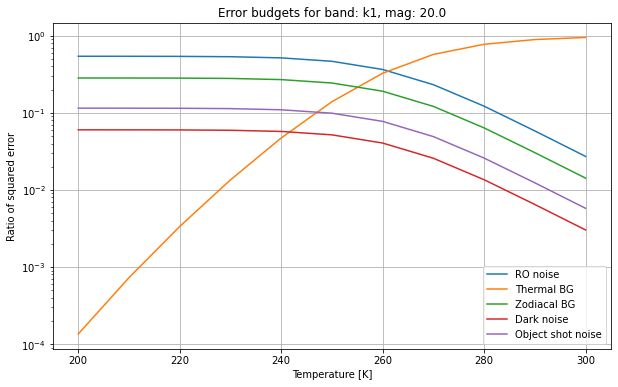

In [51]:
plt.figure(figsize=(10,6))
plt.title('Error budgets for band: {}, mag: {}'.format(band, mag))
plt.grid()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Ratio of squared error')
plt.plot(tb_sols['temperature'], tb_sols['ron_sq']/tb_sols['total_noise'], label = 'RO noise')
plt.plot(tb_sols['temperature'], tb_sols['ph_th']/tb_sols['total_noise'], label = 'Thermal BG')
plt.plot(tb_sols['temperature'], tb_sols['ph_zd']/tb_sols['total_noise'], label = 'Zodiacal BG')
plt.plot(tb_sols['temperature'], tb_sols['ph_dk']/tb_sols['total_noise'], label = 'Dark noise')
plt.plot(tb_sols['temperature'], tb_sols['ph_obj']/tb_sols['total_noise'], label = 'Object shot noise')
plt.legend()
plt.show()

# Calculation for actual parameters.

In [52]:
from astropy.table import QTable
from scipy.optimize import fsolve
import sys

In [53]:
t1 = 200.0
t2 = 300.0
tn = 41
n_pix = 9  # number of pixels of a photometry aperture.
n_frames = 5 # number of frames.
emissivity_m1 = 0.1
tbls = {}
sn_criterion = 10
mag_solve_init = 20.0  # Initial magnitude for fsolve.
for band in ['k0', 'k1', 'k2', 'k3']:
    print(band)
    temps = []
    mags = []
    counter = 0
    for temperature in np.linspace(t1, t2, tn):
        def func(x, params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion):
            return (get_signals_and_noises(params, temperature, x, band, n_pix, n_frames,
                                           cone_solangle, emissivity_m1)[3] -
                    sn_criterion)
        # Get solution of temperature for sn_ratio(temperature) = sn_criterion.
        root = fsolve(func, mag_solve_init,
                      args=(params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion))
        #for mag in np.linspace(15.0, 22.0, 101):
        #    #print(band, mag)
        #    result = get_signals_and_noises(params, temperature, mag, band, n_pix, n_frames, emissivity_m1)
        #    if result[3] < 10.0:
        #        temps.append(temperature)
        #        mags.append(mag)
        #        #print('{:s} {:.2f} {:.2f}'.format(band, temperature, mag))
        #        break
        temps.append(temperature)
        mags.append(root[0])
        sys.stdout.write(' {:d}'.format(counter))
        sys.stdout.flush()
        counter += 1
    sys.stdout.write('\n')
    t = QTable([np.array(temps), np.array(mags)], names=('temperature', 'mag'))
    tbls[band] = t

k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k1
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k2
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k3
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


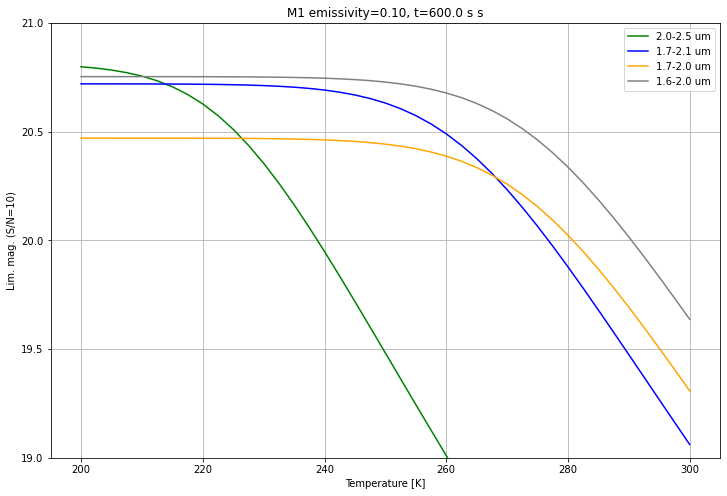

In [54]:
plt.figure(figsize=(12,8))
plt.grid()
#plt.xlim([18, 22])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, t={:.1f} s'.format(emissivity_m1, params.t_exp*n_frames))
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '2.0-2.5 um', color='green')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1.7-2.1 um', color='blue')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '1.7-2.0 um', color='orange')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '1.6-2.0 um', color='gray')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

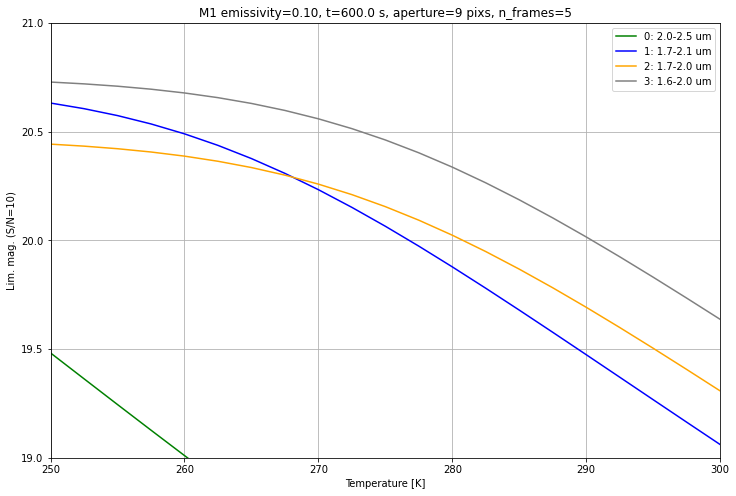

In [55]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([250, 300])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, t={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '0: 2.0-2.5 um', color='green')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1: 1.7-2.1 um', color='blue')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '2: 1.7-2.0 um', color='orange')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '3: 1.6-2.0 um', color='gray')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [56]:
from astropy.table import hstack, join

In [57]:
join(tbls['k0'], tbls['k1'], keys='temperature')

<QTable length=41>
temperature       mag_1              mag_2       
  float64        float64            float64      
----------- ------------------ ------------------
      200.0  20.79837364131086  20.71978788451025
      202.5 20.792060361419566  20.71974399645362
      205.0 20.783318952047015 20.719678129133513
      207.5 20.771379255657408 20.719580259966992
      210.0 20.755312415138757 20.719436240916686
      212.5 20.734045513442275  20.71922628567789
      215.0 20.706406535542577   20.7189229744879
      217.5 20.671206716353357 20.718488650803437
      220.0 20.627358853269953 20.717872063585816
      222.5  20.57401640006106   20.7170040922228
        ...                ...                ...
      277.5  18.23312333677622 19.973277089657365
      280.0 18.128565458594338  19.87794179799597
      282.5  18.02565719489151 19.779644957580636
      285.0 17.924384188529974 19.679145576882085
      287.5 17.824727073068342  19.57711241267958
      290.0 17.726662815757404 19.474118475896034
      292.5 17.630165750871644 19.370643795295237
      295.0  17.53520837456221 19.267083127167425
      297.5 17.441761955951602 19.163756067687682
      300.0 17.349797006469355 19.060917828200513

In [58]:
hstack([tbls['k0']['temperature'], hstack([tbls[key]['mag'] for key in tbls])]).show_in_notebook()

mag1: mag('k0'), mag2: mag('k1'), ...

Save table into an ASCII file.

In [59]:
tbls_stack = hstack([tbls['k0']['temperature'], hstack([tbls[key]['mag'] for key in tbls])])
tbls_stack.write('hgz_t_lmag_e0010_rev2.dat', format='ascii')

OSError: File hgz_t_lmag_e0010_rev2.dat already exists. If you mean to replace it then use the argument "overwrite=True".

In [60]:
!ls *.dat

hgz_t_lmag_e0010.dat      hgz_t_lmag_e0010_rev.dat  hgz_t_lmag_e0010_rev2.dat


In [61]:
!head hgz_t_lmag_e0010_rev2.dat

temperature mag_1 mag_2 mag_3 mag_4
200.0 20.79837364131086 20.71978788451025 20.47023601574363 20.753001587850594
202.5 20.792060361419566 20.71974399645362 20.47022617647452 20.752992793926573
205.0 20.783318952047015 20.719678129133513 20.47021110076878 20.75297931707586
207.5 20.771379255657408 20.719580259966992 20.47018824272939 20.75295887873897
210.0 20.755312415138757 20.719436240916686 20.470153933747927 20.752928194493332
212.5 20.734045513442275 20.71922628567789 20.470102937716792 20.752882574972325
215.0 20.706406535542577 20.7189229744879 20.470027850154008 20.752815386413896
217.5 20.671206716353357 20.718488650803437 20.469918293910002 20.752717328088668
220.0 20.627358853269953 20.717872063585816 20.469759852445076 20.752575473188024


# Calculate temperatures achieving required limiting magnitudes.

In [62]:
lim_req = 20.0  # Required limitting magnitude.

In [63]:
from scipy import interpolate

In [64]:
temp_root = [[], []]
for i in range(0,4):
    print(i)
    f = interpolate.interp1d(tbls['k{}'.format(i)]['temperature'], tbls['k{}'.format(i)]['mag'], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root[0].append(i)
    temp_root[1].append(fsolve(f_solve, temp_ini)[0])

0
1
2
3


In [65]:
temp_root

[[0, 1, 2, 3],
 [238.8465229331511, 276.78184151739606, 280.8069540932047, 290.4348284799114]]

In [66]:
print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Case                       Temperature [K]')
for i in range(0, 4):
    print('Case {:} ({:.1f} - {:.1f}): {:.1f}'.format(temp_root[0][i], params.band_wls['k{:1d}'.format(i)][0],
                                                           params.band_wls['k{:1d}'.format(i)][1], temp_root[1][i]))

Lim mag = 20.0
M1_emissivity = 0.1
Case                       Temperature [K]
Case 0 (2.0 um - 2.5 um): 238.8
Case 1 (1.7 um - 2.1 um): 276.8
Case 2 (1.7 um - 2.0 um): 280.8
Case 3 (1.6 um - 2.0 um): 290.4


# Estimation of thermal stray light from the telescope structure.

In [67]:
# Thermal emission of instruments (nominal incident rays from M1).
band = 'k1'
temperature = 250.0
ph_th = (bb_photon_flux_density(temperature,
                                params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_m1 * \
    #params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel *
    # params.pix_fov * n_pix).decompose().value
    params.t_exp * n_frames * (params.pixsize**2) * n_pix * params.cone_solangle).decompose().value

AttributeError: 'HZGParams' object has no attribute 'cone_solangle'

In [68]:
ph_th

1489116.6849124504

## Calculate thermal stray light from the telescope structure.

$$
p_{structure} = \int \frac{B(\lambda, T)}{hc/\lambda}\ d\lambda \times \Omega_{s} d_{pix}^2 N_{pix} t_{exp} N_{frames}\ \mathrm[photons]
$$

$$
\Omega_{s} = \Omega_{buf} - \Omega_{opt}, \\
\Omega_{opt} \sim \pi \left[\arctan\left(\frac{1}{2F}\right)\right]^2 \sim 0.00784\ \mathrm{sr}\ (\mathrm{for}\  F=10), \\
\Omega_{s}/\Omega_{opt} \sim 6.99\ (\mathrm{for}\ F=10, h_{buffle} = 100\ \mathrm{mm}, d_{det}=18.4 \mathrm{[mm}]), \\
\Omega_{s} = \Omega_{opt} \times \left(\Omega_{s}/\Omega_{opt}\right)\sim 0.00784 \times 6.99 \sim 0.548\ \mathrm{sr}
$$

In [69]:
print(cone_solangle)

0.007839286031065705 sr


In [70]:
omega_s = 0.0548 * u.sr # Solid angle for thermal stray light.
d_pix = 18.0 * u.um  # Pixel size of H1RG array.
# n_pix = 9.0  # Number of pixels of a photometry aperture.
#params.t_exp = 120.0 * u.s  # Exposure time for one exposure.
#n_frames = 5  # Number of frames.
emissivity_structure = 0.1  # Emissivity of the telescope structure.

In [71]:
# Thermal emission from the telescope structure.
ph_st = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_structure *
    omega_s * d_pix**2 * n_pix *
    params.t_exp * n_frames).decompose().value

In [72]:
ph_st

30461.43647795622

In [73]:
ph_st / ph_th

0.020456044033746852

In [74]:
print(omega_s / cone_solangle)

6.990432519343891


In [75]:
band = 'k1'
emissivity_structure = 0.1  # Same emiisivity as M1 assumed.
ph_th = (bb_photon_flux_density(temperature,
                                params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_m1 * \
    #params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel *
    # params.pix_fov * n_pix).decompose().value
    params.t_exp * n_frames * (params.pixsize**2) * n_pix * cone_solangle).decompose().value
ph_st = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_structure *
    omega_s * params.d_pix**2 * params.n_pix *
    params.t_exp * params.n_frames).decompose().value

AttributeError: 'HZGParams' object has no attribute 'd_pix'

In [76]:
ph_st / ph_th

6.990432519343893

Photon number ratio between that from the structure and from M1.

$$
\frac{p_{structure}}{p_{M1thermal}} \sim 7 * \frac{\epsilon_{structure}}{\epsilon_{M1thermal}}, \\
\epsilon_{xxx}: \mathrm{emissivity\ of\ xxx}.
$$

## Limitting magnitude for the structure with thermal emissivity = 0.3 along with h~100 mm buffle.b

factor_p_all

$$ f = 1+\left(\frac{\Omega_{buf}}{\Omega_{s}}-1\right)\frac{\epsilon_{st}}{\epsilon_{M1}} $$

$$ \Omega_{buf} = 2\pi \left(1-\cos\theta\right) = 2\pi \left(1-\frac{h}{\sqrt{r^2+h^2}}\right) $$

In [77]:
def sol_angle(r, h):
    return 2*np.pi*(1-h/math.sqrt(r**2+h**2))

In [78]:
h = 100.0  # Buffle height (mm)
fval = 10.0  # F/#
d_det = 18.4  # Detector size. (mm)

In [79]:
det_ratio_str = [1.0, 2/3, 1/2, 1/3]

In [80]:
det_ratio = 1.0
r_opt = h/(2*fval)  # Main optical rays.
r_buf = 1/2*(d_det * det_ratio + h/fval)  # Buffered optical rays.

In [81]:
def factor(omega_s, omega_buf, e_st, e_m1):
    return 1+((omega_buf/omega_s).value-1) * e_st/e_m1

In [82]:
factor(cone_solangle, sol_angle(r_buf,h), 0.3, 0.1)

21.881598967861308

In [83]:
# Considering thermal emission from the structure. p_st/p_th ~ 3.0 * (0.3/0.1) ~ 9.0
# factor_p_all = p_st/p_th + 1
factor_p_all = factor(cone_solangle, sol_angle(r_buf,h), 0.3, 0.1)

t1 = 200.0
t2 = 300.0
tn = 41
n_pix = 9  # number of pixels of a photometry aperture.
n_frames = 5 # number of frames.
emissivity_m1 = 0.1
tbls2 = {}
sn_criterion = 10
mag_solve_init = 17.0  # Initial magnitude for fsolve.
for band in ['k0', 'k1', 'k2', 'k3']:
    print(band)
    temps = []
    mags = []
    counter = 0
    for temperature in np.linspace(t1, t2, tn):
        def func(x, params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion):
            return (get_signals_and_noises(params, temperature, x, band, n_pix, n_frames, emissivity_m1,
                                           cone_solangle, factor_thermal=factor_p_all)[3] -
                    sn_criterion)
        # Get solution of temperature for sn_ratio(temperature) = sn_criterion.
        root = fsolve(func, mag_solve_init,
                      args=(params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion))
        #for mag in np.linspace(15.0, 22.0, 101):
        #    #print(band, mag)
        #    result = get_signals_and_noises(params, temperature, mag, band, n_pix, n_frames, emissivity_m1)
        #    if result[3] < 10.0:
        #        temps.append(temperature)
        #        mags.append(mag)
        #        #print('{:s} {:.2f} {:.2f}'.format(band, temperature, mag))
        #        break
        temps.append(temperature)
        mags.append(root[0])
        sys.stdout.write(' {:d}'.format(counter))
        sys.stdout.flush()
        counter += 1
    sys.stdout.write('\n')
    qt2 = QTable([np.array(temps), np.array(mags)], names=('temperature', 'mag'))
    tbls2[band] = qt2

k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k1
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k2
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k3
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


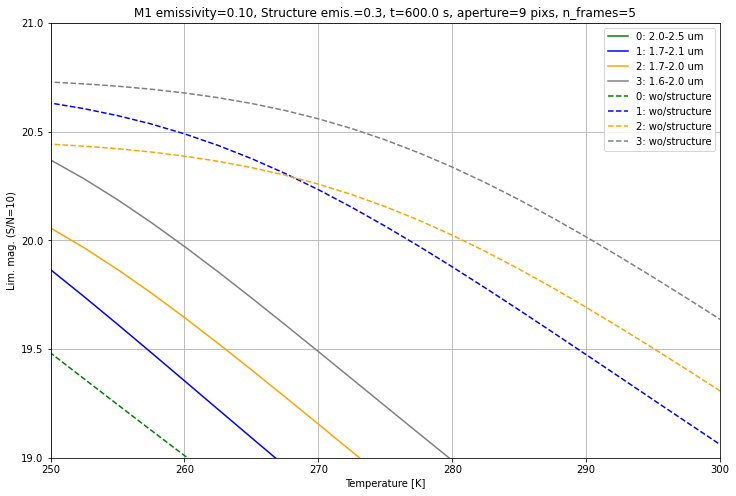

In [84]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([250, 300])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, Structure emis.=0.3, '
          't={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
plt.plot(tbls2['k0']['temperature'], tbls2['k0']['mag'], label = '0: 2.0-2.5 um', color='green')
plt.plot(tbls2['k1']['temperature'], tbls2['k1']['mag'], label = '1: 1.7-2.1 um', color='blue')
plt.plot(tbls2['k2']['temperature'], tbls2['k2']['mag'], label = '2: 1.7-2.0 um', color='orange')
plt.plot(tbls2['k3']['temperature'], tbls2['k3']['mag'], label = '3: 1.6-2.0 um', color='gray')
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '0: wo/structure', color='green', linestyle='dashed')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1: wo/structure', color='blue', linestyle='dashed')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '2: wo/structure', color='orange', linestyle='dashed')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '3: wo/structure', color='gray', linestyle='dashed')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [85]:
temp_root2 = [[], []]
for i in range(0,4):
    print(i)
    f = interpolate.interp1d(tbls2['k{}'.format(i)]['temperature'], tbls2['k{}'.format(i)]['mag'], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root2[0].append(i)
    try:
        temp_root2[1].append(fsolve(f_solve, temp_ini)[0])
    except:
        temp_root2[1].append(0.0)

print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Case    Temperature [K]  structure=0.0   0.3')
for i in range(0, 4):
    print('Case {:} ({:.1f} - {:.1f}):   {:.1f}      {:.1f}'.format(temp_root[0][i], params.band_wls['k{:1d}'.format(i)][0],
                                                           params.band_wls['k{:1d}'.format(i)][1], temp_root[1][i],
                                                             temp_root2[1][i]))

0
1
2
3
Lim mag = 20.0
M1_emissivity = 0.1
Case    Temperature [K]  structure=0.0   0.3
Case 0 (2.0 um - 2.5 um):   238.8      0.0
Case 1 (1.7 um - 2.1 um):   276.8      247.2
Case 2 (1.7 um - 2.0 um):   280.8      251.6
Case 3 (1.6 um - 2.0 um):   290.4      259.4


In [86]:
det_ratio = 3.0/4.0  # 75 % of fthe detector.
r_buf = 1/2*(d_det * det_ratio + h/fval)
factor(cone_solangle, sol_angle(r_buf,h), 0.3, 0.1)

14.846344466902549

In [87]:
# Considering thermal emission from the structure. p_st/p_th ~ 3.0 * (0.3/0.1) ~ 9.0
# factor_p_all = p_st/p_th + 1
factor_p_all = factor(cone_solangle, sol_angle(r_buf,h), 0.3, 0.1)

t1 = 200.0
t2 = 300.0
tn = 41
n_pix = 9  # number of pixels of a photometry aperture.
n_frames = 5 # number of frames.
emissivity_m1 = 0.1
tbls2 = {}
sn_criterion = 10
mag_solve_init = 17.0  # Initial magnitude for fsolve.
for band in ['k0', 'k1', 'k2', 'k3']:
    print(band)
    temps = []
    mags = []
    counter = 0
    for temperature in np.linspace(t1, t2, tn):
        def func(x, params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion):
            return (get_signals_and_noises(params, temperature, x, band, n_pix, n_frames, emissivity_m1,
                                           cone_solangle, factor_thermal=factor_p_all)[3] -
                    sn_criterion)
        # Get solution of temperature for sn_ratio(temperature) = sn_criterion.
        root = fsolve(func, mag_solve_init,
                      args=(params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion))
        #for mag in np.linspace(15.0, 22.0, 101):
        #    #print(band, mag)
        #    result = get_signals_and_noises(params, temperature, mag, band, n_pix, n_frames, emissivity_m1)
        #    if result[3] < 10.0:
        #        temps.append(temperature)
        #        mags.append(mag)
        #        #print('{:s} {:.2f} {:.2f}'.format(band, temperature, mag))
        #        break
        temps.append(temperature)
        mags.append(root[0])
        sys.stdout.write(' {:d}'.format(counter))
        sys.stdout.flush()
        counter += 1
    sys.stdout.write('\n')
    qt2 = QTable([np.array(temps), np.array(mags)], names=('temperature', 'mag'))
    tbls2[band] = qt2

k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k1
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k2
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k3
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


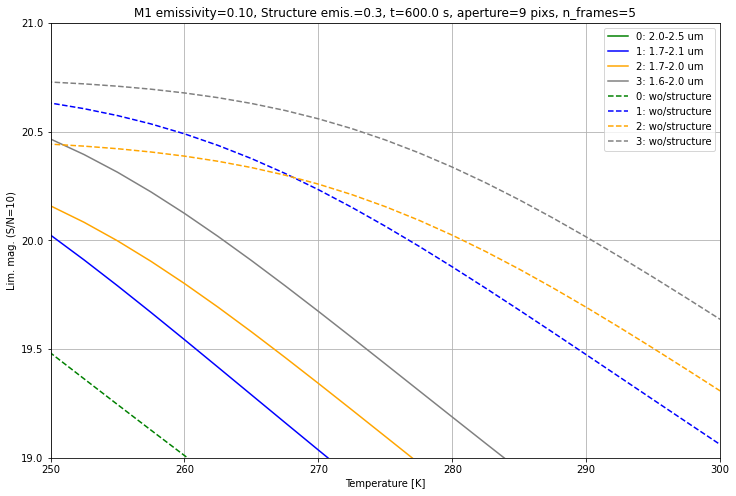

In [88]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([250, 300])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, Structure emis.=0.3, '
          't={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
plt.plot(tbls2['k0']['temperature'], tbls2['k0']['mag'], label = '0: 2.0-2.5 um', color='green')
plt.plot(tbls2['k1']['temperature'], tbls2['k1']['mag'], label = '1: 1.7-2.1 um', color='blue')
plt.plot(tbls2['k2']['temperature'], tbls2['k2']['mag'], label = '2: 1.7-2.0 um', color='orange')
plt.plot(tbls2['k3']['temperature'], tbls2['k3']['mag'], label = '3: 1.6-2.0 um', color='gray')
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '0: wo/structure', color='green', linestyle='dashed')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1: wo/structure', color='blue', linestyle='dashed')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '2: wo/structure', color='orange', linestyle='dashed')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '3: wo/structure', color='gray', linestyle='dashed')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [89]:
temp_root2 = [[], []]
for i in range(0,4):
    print(i)
    f = interpolate.interp1d(tbls2['k{}'.format(i)]['temperature'], tbls2['k{}'.format(i)]['mag'], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root2[0].append(i)
    temp_root2[1].append(fsolve(f_solve, temp_ini)[0])

print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Case    Temperature [K]  structure=0.0   0.3')
for i in range(0, 4):
    print('Case {:} ({:.1f} - {:.1f}):   {:.1f}      {:.1f}'.format(temp_root[0][i], params.band_wls['k{:1d}'.format(i)][0],
                                                           params.band_wls['k{:1d}'.format(i)][1], temp_root[1][i],
                                                             temp_root2[1][i]))

0
1
2
3
Lim mag = 20.0
M1_emissivity = 0.1
Case    Temperature [K]  structure=0.0   0.3
Case 0 (2.0 um - 2.5 um):   238.8      215.7
Case 1 (1.7 um - 2.1 um):   276.8      250.5
Case 2 (1.7 um - 2.0 um):   280.8      254.9
Case 3 (1.6 um - 2.0 um):   290.4      262.9


In [90]:
det_ratio = 2.0/4.0  # 50 % of the detector.
r_buf = 1/2*(d_det * det_ratio + h/fval)  #

In [91]:
factor(cone_solangle, sol_angle(r_buf,h), 0.3, 0.1)

9.003930662465503

In [92]:
# Considering thermal emission from the structure. p_st/p_th ~ 3.0 * (0.3/0.1) ~ 9.0
# factor_p_all = p_st/p_th + 1
factor_p_all = factor(cone_solangle, sol_angle(r_buf,h), 0.3, 0.1)

t1 = 200.0
t2 = 300.0
tn = 41
n_pix = 9  # number of pixels of a photometry aperture.
n_frames = 5 # number of frames.
emissivity_m1 = 0.1
tbls2 = {}
sn_criterion = 10
mag_solve_init = 17.0  # Initial magnitude for fsolve.
for band in ['k0', 'k1', 'k2', 'k3']:
    print(band)
    temps = []
    mags = []
    counter = 0
    for temperature in np.linspace(t1, t2, tn):
        def func(x, params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion):
            return (get_signals_and_noises(params, temperature, x, band, n_pix, n_frames, emissivity_m1,
                                           cone_solangle, factor_thermal=factor_p_all)[3] -
                    sn_criterion)
        # Get solution of temperature for sn_ratio(temperature) = sn_criterion.
        root = fsolve(func, mag_solve_init,
                      args=(params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion))
        #for mag in np.linspace(15.0, 22.0, 101):
        #    #print(band, mag)
        #    result = get_signals_and_noises(params, temperature, mag, band, n_pix, n_frames, emissivity_m1)
        #    if result[3] < 10.0:
        #        temps.append(temperature)
        #        mags.append(mag)
        #        #print('{:s} {:.2f} {:.2f}'.format(band, temperature, mag))
        #        break
        temps.append(temperature)
        mags.append(root[0])
        sys.stdout.write(' {:d}'.format(counter))
        sys.stdout.flush()
        counter += 1
    sys.stdout.write('\n')
    qt2 = QTable([np.array(temps), np.array(mags)], names=('temperature', 'mag'))
    tbls2[band] = qt2

k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k1
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k2
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k3
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


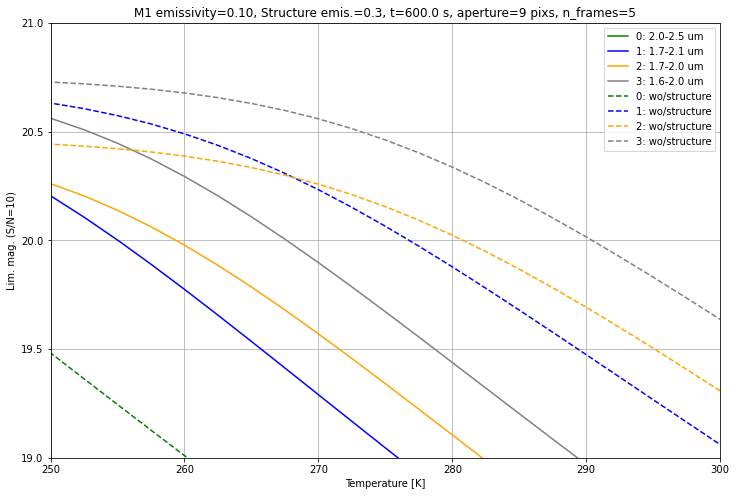

In [93]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([250, 300])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, Structure emis.=0.3, '
          't={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
plt.plot(tbls2['k0']['temperature'], tbls2['k0']['mag'], label = '0: 2.0-2.5 um', color='green')
plt.plot(tbls2['k1']['temperature'], tbls2['k1']['mag'], label = '1: 1.7-2.1 um', color='blue')
plt.plot(tbls2['k2']['temperature'], tbls2['k2']['mag'], label = '2: 1.7-2.0 um', color='orange')
plt.plot(tbls2['k3']['temperature'], tbls2['k3']['mag'], label = '3: 1.6-2.0 um', color='gray')
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '0: wo/structure', color='green', linestyle='dashed')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1: wo/structure', color='blue', linestyle='dashed')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '2: wo/structure', color='orange', linestyle='dashed')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '3: wo/structure', color='gray', linestyle='dashed')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [94]:
temp_root2 = [[], []]
for i in range(0,4):
    print(i)
    f = interpolate.interp1d(tbls2['k{}'.format(i)]['temperature'], tbls2['k{}'.format(i)]['mag'], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root2[0].append(i)
    temp_root2[1].append(fsolve(f_solve, temp_ini)[0])

print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Case    Temperature [K]  structure=0.0   0.3')
for i in range(0, 4):
    print('Case {:} ({:.1f} - {:.1f}):   {:.1f}      {:.1f}'.format(temp_root[0][i], params.band_wls['k{:1d}'.format(i)][0],
                                                           params.band_wls['k{:1d}'.format(i)][1], temp_root[1][i],
                                                             temp_root2[1][i]))

0
1
2
3
Lim mag = 20.0
M1_emissivity = 0.1
Case    Temperature [K]  structure=0.0   0.3
Case 0 (2.0 um - 2.5 um):   238.8      219.6
Case 1 (1.7 um - 2.1 um):   276.8      255.0
Case 2 (1.7 um - 2.0 um):   280.8      259.4
Case 3 (1.6 um - 2.0 um):   290.4      267.6


# Case 0 Temperature criterion
2022-06-14 H. Akitaya

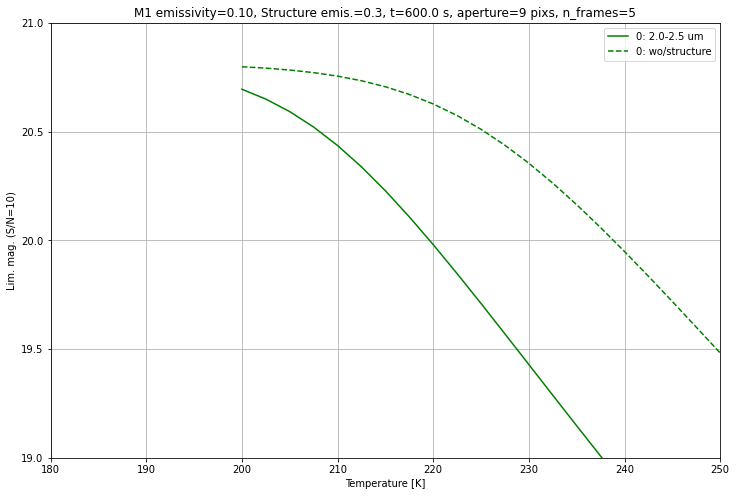

In [96]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([180, 250])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, Structure emis.=0.3, '
          't={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
plt.plot(tbls2['k0']['temperature'], tbls2['k0']['mag'], label = '0: 2.0-2.5 um', color='green')
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '0: wo/structure', color='green', linestyle='dashed')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [134]:
def get_lmag_temp_tables(params: simimg.HZGParams, cone_solangle, r_buf=r_buf, h=h, em_structure=0.3, emissivity_m1=0.1):
    factor_p_all = factor(cone_solangle, sol_angle(r_buf,h), em_structure, emissivity_m1)
    t1 = 180.0
    t2 = 300.0
    tn = 41
    n_pix = 9  # number of pixels of a photometry aperture.
    n_frames = 5 # number of frames.
    # emissivity_m1 = 0.1
    tbls2 = {}
    sn_criterion = 10
    mag_solve_init = 17.0  # Initial magnitude for fsolve.
    for band in ['k0']:
        print(band)
        temps = []
        mags = []
        counter = 0
        for temperature in np.linspace(t1, t2, tn):
            def func(x, params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion):
                return (get_signals_and_noises(params, temperature, x, band, n_pix, n_frames, emissivity_m1,
                                               cone_solangle, factor_thermal=factor_p_all)[3] -
                        sn_criterion)
            # Get solution of temperature for sn_ratio(temperature) = sn_criterion.
            root = fsolve(func, mag_solve_init,
                          args=(params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion))
            temps.append(temperature)
            mags.append(root[0])
            sys.stdout.write(' {:d}'.format(counter))
            sys.stdout.flush()
            counter += 1
        sys.stdout.write('\n')
        qt2 = QTable([np.array(temps), np.array(mags)], names=('temperature', 'mag'))
        tbls2[band] = qt2
    return tbls2

In [136]:
em_structures = np.linspace(0, 6, 7) * 0.1
tbls_k0 = {}
for em_structure in em_structures:
    print('emissivity: {:.1f}'.format(em_structure))
    tbls_k0[em_structure] = get_lmag_temp_tables(params, cone_solangle, r_buf=r_buf, h=h, em_structure=em_structure, emissivity_m1=0.1)

emissivity: 0.0
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
emissivity: 0.1
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
emissivity: 0.2
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
emissivity: 0.3
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
emissivity: 0.4
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
emissivity: 0.5
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
emissivity: 0.6
k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


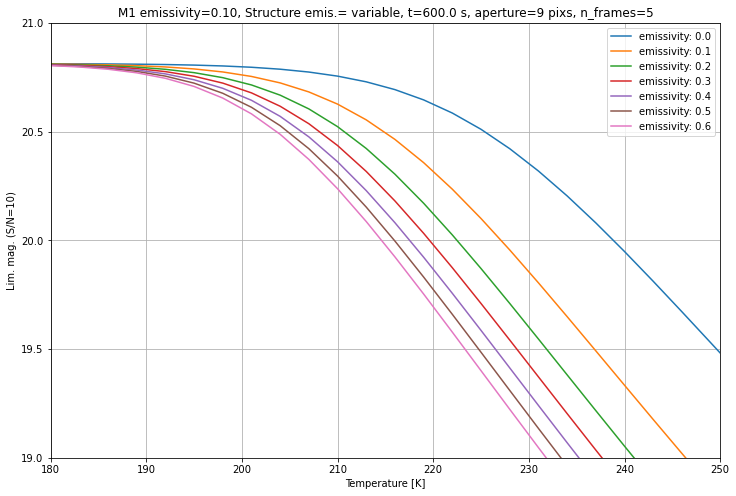

In [137]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([180, 250])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, Structure emis.= variable, '
          't={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
for em_structure in tbls_k0.keys():
    plt.plot(tbls_k0[em_structure]['k0']['temperature'], tbls_k0[em_structure]['k0']['mag'], label = 'emissivity: {:.1f}'.format(em_structure))
plt.legend()
plt.show()


In [160]:
temp_root2 = [[], []]
lim_req = 20.5
for em_structure in em_structures:
    f = interpolate.interp1d(tbls_k0[em_structure]['k0']['temperature'], tbls_k0[em_structure]['k0']['mag'], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root2[0].append(em_structure)
    temp_root2[1].append(fsolve(f_solve, temp_ini)[0])

print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Structure_emissivity Temperature')
i=0
for em_structure in em_structures:
    print('{:.2f}                 {:.2f}'.format(em_structure, temp_root2[1][i]))
    i+=1

Lim mag = 20.5
M1_emissivity = 0.1
Structure_emissivity Temperature
0.00                 225.39
0.10                 214.88
0.20                 210.74
0.30                 208.16
0.40                 206.29
0.50                 204.84
0.60                 203.65


In [161]:
temp_root3 = [[], []]
lim_req = 20.0
for em_structure in em_structures:
    f = interpolate.interp1d(tbls_k0[em_structure]['k0']['temperature'], tbls_k0[em_structure]['k0']['mag'], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root3[0].append(em_structure)
    temp_root3[1].append(fsolve(f_solve, temp_ini)[0])

print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Structure_emissivity Temperature')
i=0
for em_structure in em_structures:
    print('{:.2f}                 {:.2f}'.format(em_structure, temp_root3[1][i]))
    i+=1

Lim mag = 20.0
M1_emissivity = 0.1
Structure_emissivity Temperature
0.00                 238.85
0.10                 227.10
0.20                 222.49
0.30                 219.63
0.40                 217.56
0.50                 215.94
0.60                 214.62


In [217]:
print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Structure_emissivity Temperature(20.0mag) (20.5mag)')
i=0
for em_structure in em_structures:
    print('{:.2f}                 {:.2f}               {:.2f}'.format(em_structure, temp_root3[1][i], temp_root2[1][i]))
    i+=1

Lim mag = 20.0
M1_emissivity = 0.1
Structure_emissivity Temperature(20.0mag) (20.5mag)
0.00                 238.85               225.39
0.10                 227.10               214.88
0.20                 222.49               210.74
0.30                 219.63               208.16
0.40                 217.56               206.29
0.50                 215.94               204.84
0.60                 214.62               203.65


In [172]:
temp_root_merge = temp_root2 + temp_root3

In [173]:
temp_root_merge

[[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001],
 [225.38713422261898,
  214.8769131485159,
  210.7385999996904,
  208.15953162018405,
  206.2944153757532,
  204.83808065501827,
  203.6462715639563],
 [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001],
 [238.8465286358161,
  227.10151237557426,
  222.49353345309447,
  219.6266038793995,
  217.5554768611541,
  215.93963095557427,
  214.61809495589824]]

In [174]:
temp_root_ndarray = np.array(list(temp_root_merge))

In [182]:
derivative = (20.5-20.0) / (temp_root_ndarray[3] - temp_root_ndarray[2] )*10

In [183]:
derivative

array([0.02093394, 0.02202628, 0.02249278, 0.02279705, 0.02302498,
       0.02320836, 0.02336251])

In [213]:
np.stack([temp_root_ndarray, derivative], 1)

ValueError: all input arrays must have the same shape

In [ ]:
temp_criterion_tbl = Table(rows=(temp_root_merge, derivative), names=('emissivity', 'lmag20.5', 'lmag21.0', 'lmag_per_10k'))

In [206]:
temp_criterion_tbl

<Table length=2>
                            emissivity                             ...
                              object                               ...
------------------------------------------------------------------ ...
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001] ...
                                              0.020933944606847544 ...